Let's do some word counting!

From two sets of bags: one with duplicates removed (thredds) and one without. Note that there are still issues with parsers, with bag generation, with thredds.

What we're doing:

- ~~create a bag of words for each successfully parsed response (bag must have two or more words)~~
- create a bag of words from the xml text()/attrib.values (raw xml no semantic understanding, etc)
- map identity to data flag (is it a data service?)
- let's do some eda - number of words per response type (which, thought i had done that?)
- chart words per data v not data

and, if that looks reasonable, let's make a linear regression - one parameter (word count) to predict boolean data v no data.


### ! NOTE: identification is ongoing !

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import json
import glob
import string
from itertools import chain
import dateutil.parser as dateparser
from semproc.nlp_utils import *
from semproc.bag_parser import BagParser

In [2]:
# some odds and ends

def _prep(filepath):
    # assume this is from the identified json 
    with open(filepath, 'r') as f:
        data = json.loads(f.read())

    response = data.get('content', '')
    response = response.replace('\\\n', '').replace('\r\n', '').replace('\\r', '').replace('\\n', '').replace('\n', '')
    response = response.decode('utf-8', errors='replace').encode('unicode_escape')
    
    identity = data.get('identity', [])
    url = data.get('source_url', '')
    
    return identity, response, url

In [25]:
files = ['/Users/sscott/Documents/tmp/identified/0a87b35f00a9a9c4b6b884ddf7cb210e_identified.json']

files = glob.glob('/Users/sscott/Documents/tmp/identified/*_identified.json')

In [14]:
# not using this - too specific
exclude_tags = ['@schemaLocation', '@codeList']

remove:

- urls
- dates
- numbers
- urns
- emails
- hashes (uuids, md5, sha if possible)


My assumptions regarding the linear regression model:

First, we have to make some guesses about what is or isn't a data response. This is before any true modeling or semantic inference so I am relying solely on the response type. Namely, that OGC services are data (spatial or time series data, at least), FGDC, ISO and DIF are likely to refer to data, OAI-PMH, OpenSearch, feeds (RSS or ATOM) are unclear (they could refer to data but that is the larger NLP question). I am going to lump CSW in these possible-but-not-known data services today.

In [10]:
# some of the processing methods

stopword_corpora = [
    "mimetypes.txt",
    "namespaces.txt"
]

# TODO: this is clearly unwarranted copypasta
def remove_urls(text_as_list):
    pttn = re.compile(ur"((?:(?:https?|ftp|http)://)(?:\S+(?::\S*)?@)?(?:(?!(?:10|127)(?:.\d{1,3}){3})(?!(?:169.254|192.168)(?:.\d{1,3}){2})(?!172.(?:1[6-9]|2\d|3[0-1])(?:.\d{1,3}){2})(?:[1-9]\d?|1\d\d|2[01]\d|22[0-3])(?:.(?:1?\d{1,2}|2[0-4]\d|25[0-5])){2}(?:.(?:[1-9]\d?|1\d\d|2[0-4]\d|25[0-4]))|(?:(?:[a-z\\u00a1-\\uffff0-9]-*)*[a-z\\u00a1-\\uffff0-9]+)(?:.(?:[a-z\\u00a1-\\uffff0-9]-*)*[a-z\\u00a1-\\uffff0-9]+)*(?:.(?:[a-z\\u00a1-\\uffff]{2,})))(?::\d{2,5})?(?:/\S*)?)", re.IGNORECASE)
    new_text = []
    for text in text_as_list:
        if pttn.search(text) is None:
            new_text.append(text)
    return new_text

def remove_urns(text_as_list):
    pttn = re.compile(ur"(?![http://])(?![https://])(?![ftp://])(([a-z0-9.\S][a-z0-9-.\S]{0,}\S:{1,2}\S)+[a-z0-9()+,\-.=@;$_!*'%/?#]+)", re.IGNORECASE)
    new_text = []
    for text in text_as_list:
        if pttn.search(text) is None:
            new_text.append(text)
    return new_text

def remove_hashes(text_as_list):
    # uuids and md5s
    pttns = [
        re.compile(ur"([a-f0-9]{32})", re.IGNORECASE),
        re.compile(ur'([a-f\d]{8}(-[a-f\d]{4}){3}-[a-f\d]{12}?)', re.IGNORECASE)
    ]
    new_text = []
    for text in text_as_list:
        found = 0
        for pttn in pttns:
            if pttn.search(text) is not None:
                found += 1
        if not found:      
            new_text.append(text)
    return new_text

def remove_timestamps(text_as_list):
    new_text = []
    for text in text_as_list:
        try:
            d = dateparser.parse(text)
        except:
            new_text.append(text)
    return new_text

def remove_emails(text_as_list):
    pttn = re.compile(ur'(\w+[.|\w])*@(\w+[.])*\w+', re.IGNORECASE)
    new_text = []
    for text in text_as_list:
        if pttn.search(text) is None:
            new_text.append(text)
    return new_text

def remove_numberlike(text_as_list):
    # remove anything that is just numbers or punctuation
    # and in a dinky way. do not care.
    new_text = []
    for text in text_as_list:
        try:
            txt = str(text)
            x = ''.join([t for t in txt if str.isdigit(t) or t in string.punctuation])
            if len(x) != len(text):
                new_text.append(text)
        except:
            # wow, we're just not caring right now
            new_text.append(text)
        
    return new_text

def remove_punctuation(text_as_list):
    '''
    remove any punctuation from the text (for
        bag of words to be just words)
    '''
    simple_pattern = r'[;|>+:=.,()/?!\[\]{}]'
    
    new_text = []
    for text in text_as_list:
        text = re.sub(simple_pattern, ' ', text)
        # catch the singleton hyphens
        text = text.replace(' - ', ' ')
        if text:
            new_text.append(text)
    return new_text
    

def handle_whitespace(text):
    text = ' '.join(text.strip().split())
    return text.split()

def split_things(text_as_list):
    simple_pattern = r'[/:.]'
    new_text = [re.split(simple_pattern, text) for text in text_as_list]
    new_text = list(chain.from_iterable(new_text))
    return [text for text in new_text if text]

In [28]:
# the url, protocol, raw count and distinct count
stats = []

count_if_identified = 0
limit = 100

for f in files:
    identity, response, url = _prep(f)
    
    if not identity:
        continue
    
    if not [i for i in identity if i.get('protocol', '') in ['ISO', 'OGC', 'OAI-PMH', 'FGDC']]:
        continue
    
    if count_if_identified > limit:
        break
    
    # we're going to ignore any <a> tags embedded in the text content
    # but if we don't want to do that later, it throws bs4 warnings (fyi).
    parser = BagParser(response, True, False)
    bag = [handle_whitespace(b[1]) for b in parser.strip_text()]

    # flatten the response (we are tokenizing on the whitespace only)
    bag = list(chain.from_iterable(bag))

    # try to chuck the urls and urns
    bag = remove_urls(bag)
    bag = remove_emails(bag)
    bag = remove_urns(bag)
    bag = remove_hashes(bag)
    bag = remove_timestamps(bag)
    bag = remove_numberlike(bag)
    
    # note that we kinda don't care about some of the left over bits
    # of punctuation for the simple count tests (it's a word either way)
    # BUT if we go with DISTINCT words or the later BoW NLP work,
    # we will care so... anyway, i'm just going to care now
    
    bag = remove_punctuation(bag)
    
    # and one more round of whitespace (split and strip)
    new_bag = []
    for b in bag:
        parts = b.split(' ')
        for p in parts:
            # and just make everything unicode. safety first!
            new_bag.append(unicode(p.strip()))
    
    # split on the forward slashes (keywords but only after chucking urls)
    bag = split_things(new_bag)

    # we'll not remove actual stopwords, fyi
    
    raw_count = len(bag)
    distinct_count = len(set(bag))
    
    stats.append('|'.join([url.replace('|', ';;'),
                           ';;'.join([i['protocol'] for i in identity if i.get('protocol', '') in ['ISO', 'OGC', 'OAI-PMH', 'FGDC']]),
                           str(raw_count),
                           str(distinct_count)]))
    
    count_if_identified += 1
    # print identity, raw_count, distinct_count                      
    # print bag

//anaconda/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://data.nodc.noaa.gov/coris/data/CoRIS/fgdc_schema_coris/fgdc-std-001-1998.xsd" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
//anaconda/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://gisinfo.co.walworth.wi.us/arcgis/rest/services/1956Orthophotography/MapServer/WMTS/1.0.0/WMTSCapabilities.xml" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get th

KeyboardInterrupt: 

In [29]:
with open('data_v_word_counts_20150713.csv', 'w') as f:
    f.write('url|protocol|raw|distinct\n')
    f.write('\n'.join(stats))

In [30]:
len(stats)

44

### the next steps

run the counts

get some samples by protocol (hook up postgres and do that)

run the linear regression

let's make a chart!


In [1]:
# len('82A5DD195658CBECE040AC8C5AB41A40') = 32




32

## THIS IS OUT-OF-DATE 

but hanging on to it for a bit.

In [45]:
import os
import glob
import json

identified_bows = []

for f in glob.glob('../solr_superset/bags_of_words_no_dupes/*.txt'):
    with open(f, 'r') as g:
        bow = g.read()
    
    c = len([b for b in bow.split() if b])
    
    basename = os.path.basename(f).split('_')[0]
    
    # go get the identified result and see what it is
    ip = os.path.join('../solr_superset/identified/', basename + '_identified.json')
    if not os.path.exists(ip):
        print 'missing file: ', ip
        continue
    
    with open(ip, 'r') as g:
        data = json.loads(g.read())
    
    protocol = data.get('identity', {}).get('protocol', '')
    
    if not protocol:
        print 'no identity: ', f
        continue
    
    identified_bows.append((f, c, protocol))

identified_bows[:5]


[('../solr_superset/bags_of_words_no_dupes/0005001cd381e9613dc44fe6efafdf08_parsed_bow.txt',
  178,
  u'ISO-19115'),
 ('../solr_superset/bags_of_words_no_dupes/00164fc758489d7c671f939d6c533bad_parsed_bow.txt',
  107,
  u'ISO-19115'),
 ('../solr_superset/bags_of_words_no_dupes/001ef148783e50940d569316c6b6d608_parsed_bow.txt',
  4,
  u'UNIDATA'),
 ('../solr_superset/bags_of_words_no_dupes/003492e5f3a49d31f697200a7f427122_parsed_bow.txt',
  182,
  u'ISO-19115'),
 ('../solr_superset/bags_of_words_no_dupes/004749541a8acce4f454dd95f6b0c4c9_parsed_bow.txt',
  3,
  u'OpenSearch')]

In [ ]:
# let's make some better bags of words


{'mean': {u'ISO-19115': 105.63237979306147,
  u'OAI-PMH': 3.2941176470588234,
  u'OGC:CSW': 19.0,
  u'OGC:SOS': 81.333333333333329,
  u'OGC:WCS': 33.81818181818182,
  u'OGC:WFS': 19.572815533980581,
  u'OGC:WMS': 51.650406504065039,
  u'OpenSearch': 10.553088803088803,
  u'UNIDATA': 9.5384615384615383}}

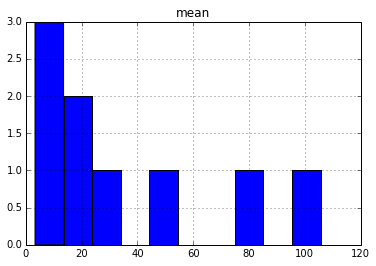

In [41]:
import pandas as pd
import numpy as np


pd.set_option('precision',2)

df = pd.DataFrame(identified_bows, columns=['file', 'count', 'protocol'])

p_df = df.groupby(df['protocol'])
#p_df.agg([np.mean])

p_df = df.groupby(df['protocol']).agg({'count': {'mean':'mean'}})

p_df.columns = p_df.columns.droplevel(0)

df.groupby(df['protocol']).agg({'count': {'mean':'mean'}})['count'].hist()

p_dt = p_df.to_dict()

p_dt

In [40]:
#new_df = p_df.agg([np.mean])
new_df['count']


,mean
protocol,
ISO-19115,105.6
OAI-PMH,3.3
OGC:CSW,19.0
OGC:SOS,81.3
OGC:WCS,33.8
OGC:WFS,19.6
OGC:WMS,51.7
OpenSearch,10.6
UNIDATA,9.5


In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

xlocations = np.array(range(len(p_dt['mean'].keys())))+0.5

fig, ax = plt.subplots()

ax.bar(xLocations, p_dt['mean'].values(0, width=200)
xticks(xLocations+200/2, p_dt['mean'].keys())

plt.show()

SyntaxError: invalid syntax (<ipython-input-43-169aae5eeb7b>, line 9)